In [42]:
from edgeml import edgeml
import pandas as pd
import tsfresh as ts
import seaborn as sns
import matplotlib.pyplot as plt
import math

In [2]:
project = edgeml.getProject("https://app.edge-ml.org",
                            "dSCctVkGbmT/tMoPX4u6/2lzjQ82zWLweyUpBP7C/oYeXtNGi9iyiwMXr+JTbBzh+Yk1Oh/kJZiiGM/y6HLj2Q==")

fetching project...


In [3]:
data_list = []
for dataset in project["datasets"]:
    label = dataset['labels'][0][0]['name']
    data_obj = {}
    for sensor in dataset["sensors"]:
        sensor_name = sensor['name']
        for datapoint in sensor["data"]:
            if datapoint['timestamp'] not in data_obj:
                data_obj[datapoint['timestamp']] = {}
            if 'label' not in data_obj[datapoint['timestamp']]:
                data_obj[datapoint['timestamp']]['label'] = label
            data_obj[datapoint['timestamp']][sensor_name] = datapoint["datapoint"]
    df = pd.DataFrame.from_dict(data_obj, orient='index')
    df.reset_index(inplace=True)
    df.rename(columns={'index': 'timestamp'}, inplace=True)
    df['timestamp'] = pd.to_datetime(df['timestamp'] / 1000, unit='s')
    #df.to_csv(f"../data/original/{label}.csv", index=False)
    data_list.append(df)

In [4]:
data_list[0].head()

,timestamp,label,x0,y0,z0,x,y,z,alpha,beta,gamma
0,2022-08-11 10:37:02.815000064,reading,0.00,0.01,-0.02,-0.23,-6.99,-6.89,-3.19,0.38,-1.16
1,2022-08-11 10:37:02.831000064,reading,0.00,0.07,0.01,-0.22,-6.92,-6.87,-4.89,-1.07,-0.50
2,2022-08-11 10:37:02.846999808,reading,0.00,0.05,-0.12,-0.23,-6.92,-7.01,-5.93,-1.34,-0.31
3,2022-08-11 10:37:02.864000000,reading,-0.01,0.01,-0.18,-0.24,-6.96,-7.08,-5.51,0.06,-0.37
4,2022-08-11 10:37:02.880999936,reading,-0.07,-0.02,-0.20,-0.30,-6.98,-7.11,-4.69,0.42,-0.97


In [5]:
data_full = pd.DataFrame()
for data in data_list:
    data["window"] = data.apply(lambda x: x['timestamp'].round(freq="1s"), axis=1)
    label = data["label"].iloc[0]
    data.drop(columns=['timestamp', 'label'], inplace=True)
    data = ts.extract_features(data, column_id="window",
                               default_fc_parameters=ts.feature_extraction.MinimalFCParameters())
    data.reset_index(inplace=True)
    data.rename(columns={'index': 'timestamp'}, inplace=True)
    data['label'] = label
    data_full = pd.concat([data_full, data])
    #data.to_csv(f"../data/features/{label}.csv", index=False)

data_full.to_csv(f"../data/data.csv", index=False)

Feature Extraction: 100%|██████████| 30/30 [00:02<00:00, 10.55it/s]


In [6]:
data_full.head()

,timestamp,x0__sum_values,x0__median,x0__mean,x0__length,x0__standard_deviation,x0__variance,x0__root_mean_square,x0__maximum,x0__minimum,...,gamma__sum_values,gamma__median,gamma__mean,gamma__length,gamma__standard_deviation,gamma__variance,gamma__root_mean_square,gamma__maximum,gamma__minimum,label
0,2022-08-11 10:37:03,-0.16,0.000,-0.003810,42.0,0.071313,0.005085,0.071414,0.14,-0.14,...,11.56,0.170,0.275238,42.0,1.338370,1.791234,1.366379,3.20,-2.19,reading
1,2022-08-11 10:37:04,-0.53,-0.010,-0.008833,60.0,0.054163,0.002934,0.054879,0.11,-0.11,...,-3.40,0.010,-0.056667,60.0,1.025403,1.051452,1.026968,2.30,-2.16,reading
2,2022-08-11 10:37:05,-0.21,-0.010,-0.003500,60.0,0.062499,0.003906,0.062597,0.16,-0.13,...,4.46,-0.055,0.074333,60.0,1.482812,2.198731,1.484674,4.03,-2.99,reading
3,2022-08-11 10:37:06,-0.44,0.000,-0.007333,60.0,0.077800,0.006053,0.078145,0.22,-0.24,...,25.98,0.245,0.433000,60.0,1.463857,2.142878,1.526554,5.19,-3.17,reading
4,2022-08-11 10:37:07,-0.15,-0.005,-0.002500,60.0,0.053155,0.002825,0.053213,0.13,-0.11,...,-19.26,-0.185,-0.321000,60.0,0.968879,0.938726,1.020670,1.58,-2.94,reading


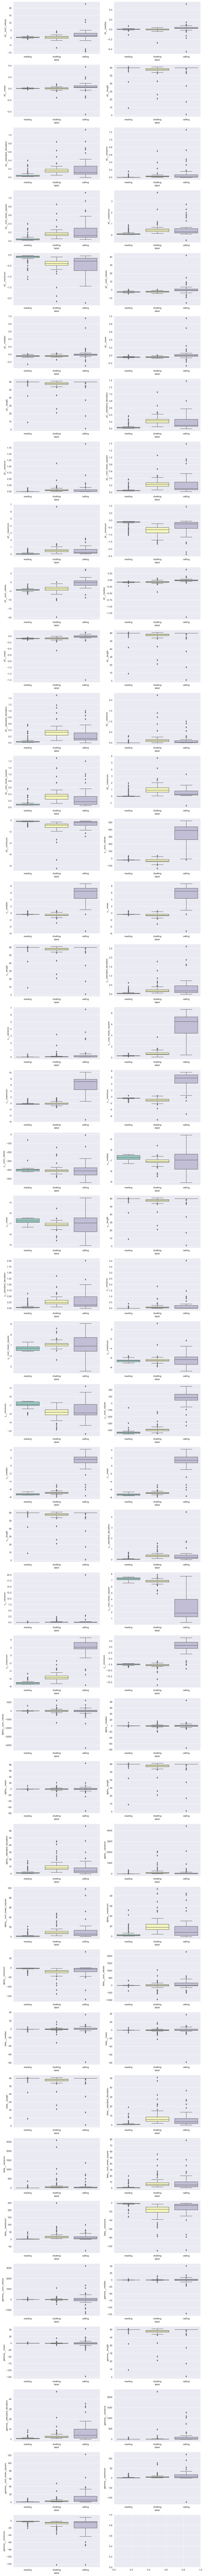

In [44]:
columns = data_full.columns.drop(['timestamp', 'label'])

fig, axes = plt.subplots(nrows=math.ceil(len(columns) / 2), ncols=2, figsize=(12, 150), dpi=140)

for i, column in enumerate(columns):
    sns.boxplot(x='label', y=column, data=data_full, ax=axes[i // 2, i % 2], palette="Set3")

fig.tight_layout()
plt.show()